# Import Library

In [87]:
import cv2
import pandas
import seaborn
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

# Convert Gambar ke Sampel

In [88]:
path = 'input/'

### Fungsi image preprocessing

In [89]:
def t_img (img) :
    return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)

def c_img (img) :
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))

def d_img (img) :
    return cv2.dilate(img, np.ones((2,2), np.uint8), iterations = 1)

def b_img (img) :
    return cv2.GaussianBlur(img, (1,1), 0)

In [90]:
import os
from PIL import Image
from keras.preprocessing.image import img_to_array, ImageDataGenerator

### Mengubah gambar menjadi array
Masing-masing gambar akan mengalami proses preprocessing yang menghasilkan output 5 karakter. Masing-masing 5 karakter tersebut akan diambil nilainya dalam array dan masuk ke variabel X dan nama dari karakter tersebut akan masuk ke variabel Y.

In [91]:
X = []
y = []

for image in os.listdir(path) :
    
    if image[6:] != 'png' :
        continue
    
    img = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
    
    img = t_img(img)
    img = c_img(img)
    img = d_img(img)
    img = b_img(img)
    
    image_list = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
    
    for i in range(5) :
        X.append(img_to_array(Image.fromarray(image_list[i])))
        y.append(image[i])
X = np.array(X)
y = np.array(y)

In [92]:
print(X.shape)
print(y.shape)

(5200, 40, 20, 1)
(5200,)


Dari proses ini menghasilkan 5200 karakter dengan dimensi masing-masing karakter 40x20x1.

# Data Wrangling
### Scale b/w 0 and 1

In [93]:
X /= 255.0

### Melihat sampel karakter

[]

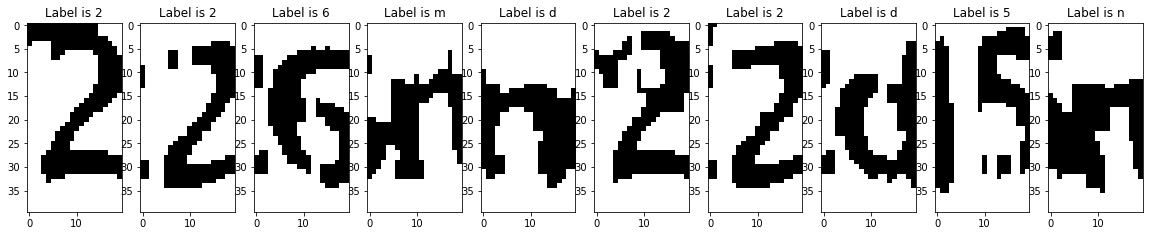

In [94]:
plt.figure(figsize = (20,5))
for i in range(10) :
    plt.subplot(1,10,i+1)
    plt.imshow(tf.squeeze(X[i]), 'gray')
    plt.title('Label is ' + str(y[i]))
plt.plot()

### Melihat jumlah masing-masing karakter

In [95]:
temp = set(y)
for t in temp :
    print('Occurance count of ' + t + ' : ' + str(len(y[y == t])))

Occurance count of x : 264
Occurance count of 7 : 258
Occurance count of 4 : 284
Occurance count of y : 232
Occurance count of p : 253
Occurance count of 8 : 264
Occurance count of 6 : 259
Occurance count of g : 271
Occurance count of 5 : 281
Occurance count of f : 271
Occurance count of w : 235
Occurance count of e : 235
Occurance count of 2 : 265
Occurance count of n : 525
Occurance count of 3 : 267
Occurance count of m : 275
Occurance count of d : 259
Occurance count of b : 240
Occurance count of c : 262


In [96]:
temp_df = pandas.DataFrame({'labels' : [t for t in temp], 'Count' : [len(y[y==t]) for t in temp]})

### Grafik persebaran karakter

Text(0.5, 1.0, 'Label distribution in CAPTCHAS')

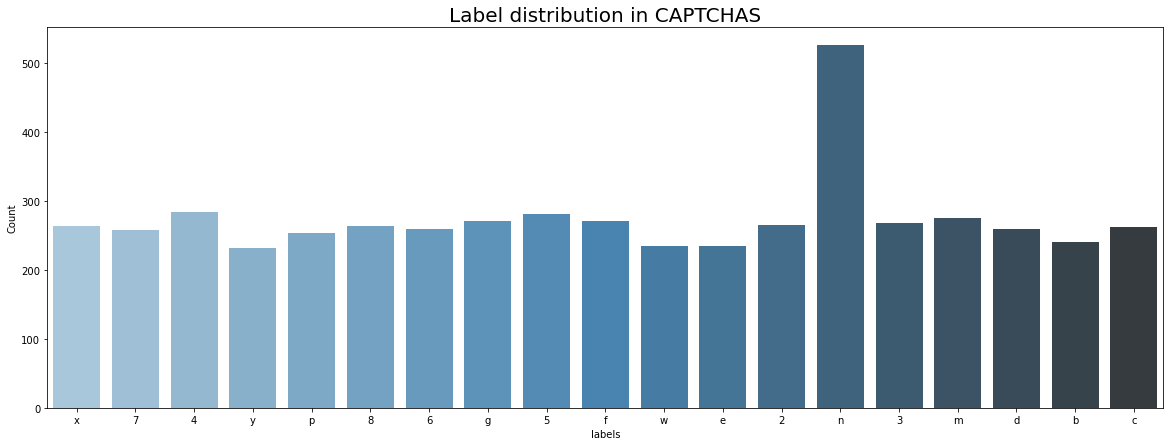

In [97]:
plt.figure(figsize = (20,7))
seaborn.barplot(x = 'labels', y = 'Count', data = temp_df, palette = 'Blues_d')
plt.title('Label distribution in CAPTCHAS', fontsize = 20)

### One hot encoding
One hot encoding adalah salah satu metode konversi data untuk mempersiapkannya untuk suatu algoritma dan mendapatkan prediksi yang lebih baik. (Mengubah data kategorikal menjadi data numerikal)

In [98]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

y_combine = LabelEncoder().fit_transform(y)
y_one_hot = OneHotEncoder(sparse = False).fit_transform(y_combine.reshape(len(y_combine),1))

In [99]:
print('letter 2 : ' + str(y[1]))
print('label : ' + str(y_combine[1]))
print('Count : ' + str(len(y_combine[y_combine == y_combine[1]])))

letter 2 : 2
label : 0
Count : 265


In [100]:
info = {y_combine[i] : y[i] for i in range(len(y))}
dict(sorted(info.items(), key=lambda x:int(x[0])))

{0: '2',
 1: '3',
 2: '4',
 3: '5',
 4: '6',
 5: '7',
 6: '8',
 7: 'b',
 8: 'c',
 9: 'd',
 10: 'e',
 11: 'f',
 12: 'g',
 13: 'm',
 14: 'n',
 15: 'p',
 16: 'w',
 17: 'x',
 18: 'y'}

### Bentuk data setelah dilakukan encoding

In [101]:
print(X.shape)
print(y_one_hot.shape)

(5200, 40, 20, 1)
(5200, 19)


# Splitting Data

In [102]:
from sklearn.model_selection import train_test_split

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size = 0.2, random_state = 1)

### Grafik persebaran Test Set

In [104]:
y_temp = np.argmax(y_test, axis = 1)

In [105]:
temp = set(y_temp)
temp_df = pandas.DataFrame({'labels' : [info[t] for t in temp], 'Count' : [len(y_temp[y_temp == t]) for t in temp]})

Text(0.5, 1.0, 'Label distribution in test set')

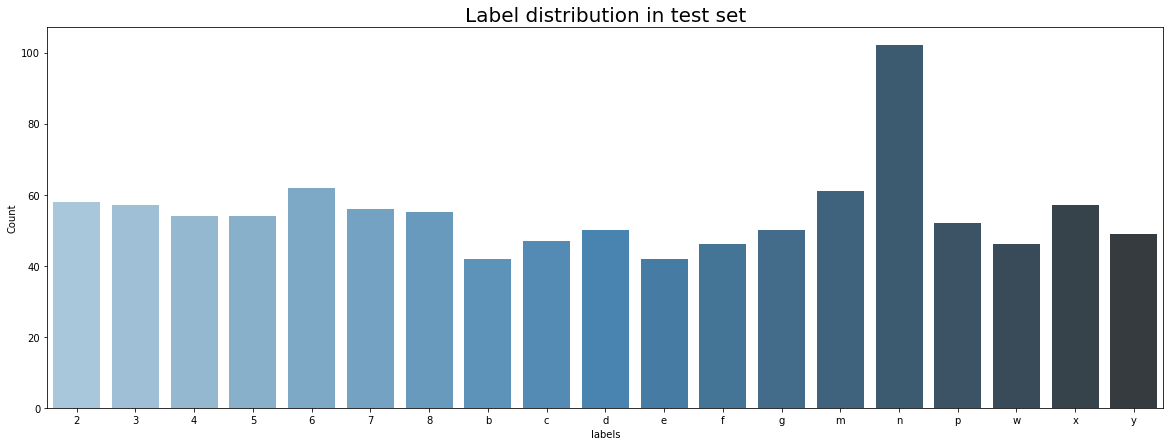

In [106]:
plt.figure(figsize = (20,7))
seaborn.barplot(x = 'labels', y = 'Count', data = temp_df, palette = 'Blues_d')
plt.title('Label distribution in test set', fontsize = 20)

In [107]:
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization

from keras.layers import Dropout
from keras.layers import Input

### Bentuk Train Set Data

In [108]:
print(X_train.shape)
print(y_train.shape)

(4160, 40, 20, 1)
(4160, 19)


### Bentuk Test Set Data

In [109]:
print(X_test.shape)
print(y_test.shape)

(1040, 40, 20, 1)
(1040, 19)


### Data Augmentation
Data Augmentation adalah teknik yang digunakan untuk menambah jumlah data dengan menambahkan salinan yang sedikit dimodifikasi dari data yang sudah ada atau data sintetis yang baru dibuat dari data yang ada.

In [110]:
traingen = ImageDataGenerator(rotation_range = 5, width_shift_range = [-2,2])
traingen.fit(X_train)

In [111]:
train_set = traingen.flow(X_train, y_train)

In [112]:
trainX, trainy = train_set.next()

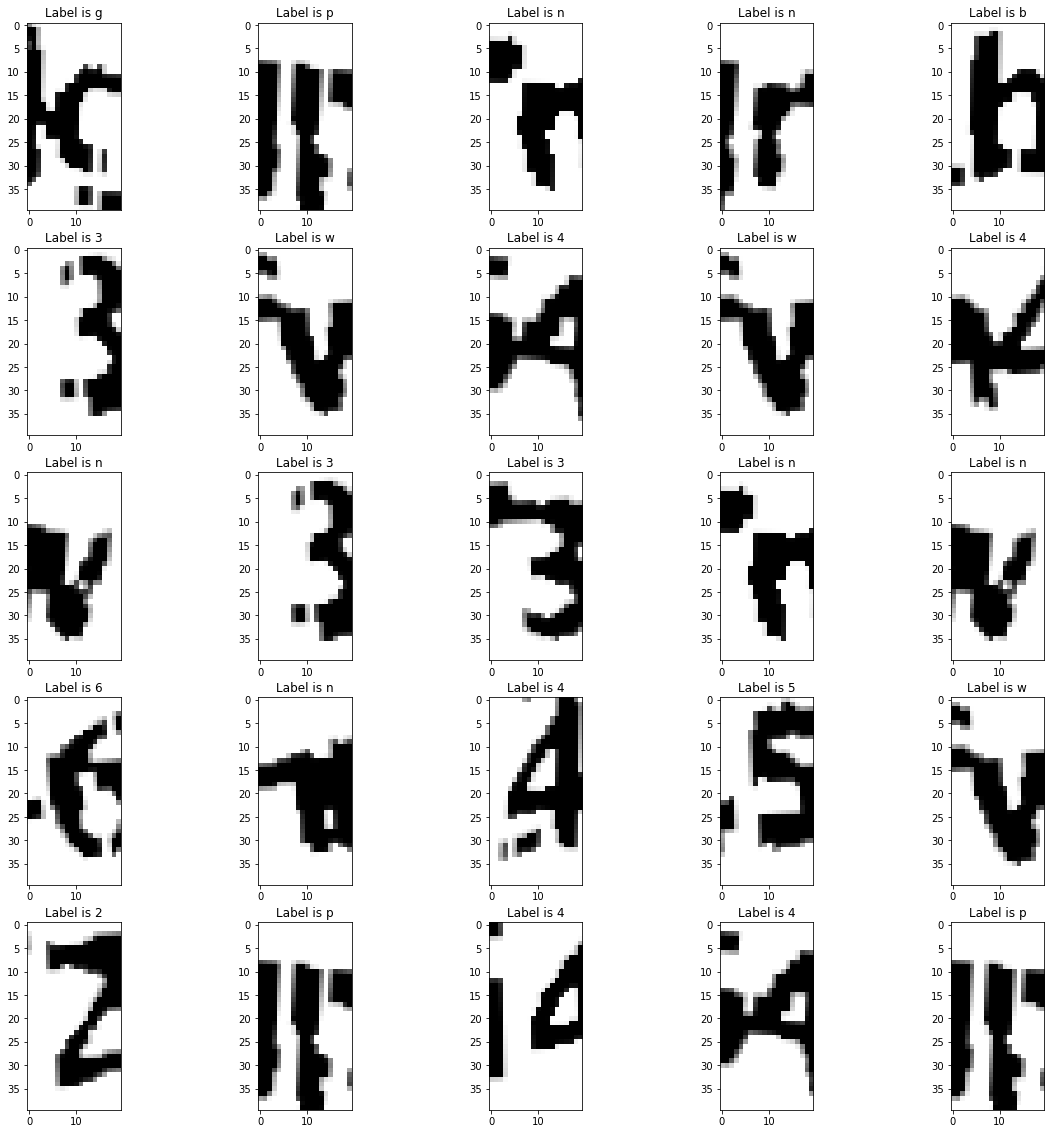

In [74]:
plt.figure(figsize = (20,20))

hi = 32
lo = 0

for i in range(25) :
    plt.subplot(5,5,i+1)
    x = np.random.randint(lo, hi)
    plt.imshow(tf.squeeze(trainX[x]), 'gray')
    plt.title('Label is ' + str(info[np.argmax(trainy[x])]))
plt.show()

# Model Evaluation

In [75]:
from keras.models import load_model

### Import model terbaik yang telah disimpan

In [76]:
model = load_model('./result_model.h5')

In [77]:
pred = model.predict(X_test)

In [115]:
X_test.shape

(1040, 40, 20, 1)

In [78]:
pred = np.argmax(pred, axis = 1)
yres = np.argmax(y_test,axis= 1)

In [79]:
from sklearn.metrics import accuracy_score, classification_report

In [80]:
target_name = []
for i in sorted(info) :
  target_name.append(info[i])
    
target_name

['2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'm',
 'n',
 'p',
 'w',
 'x',
 'y']

In [81]:
print('Accuracy : ' + str(accuracy_score(yres, pred)))
print(classification_report(yres, pred, target_names = target_name))

Accuracy : 0.8923076923076924
              precision    recall  f1-score   support

           2       0.92      0.95      0.93        58
           3       1.00      0.93      0.96        57
           4       0.87      0.98      0.92        54
           5       0.91      0.93      0.92        54
           6       0.93      0.90      0.92        62
           7       0.93      0.93      0.93        56
           8       0.98      0.95      0.96        55
           b       0.98      0.98      0.98        42
           c       0.90      0.94      0.92        47
           d       0.90      0.92      0.91        50
           e       0.90      0.83      0.86        42
           f       0.86      0.96      0.91        46
           g       0.94      0.98      0.96        50
           m       0.81      0.41      0.54        61
           n       0.69      0.94      0.80       102
           p       0.92      0.90      0.91        52
           w       0.90      0.83      0.86        

### Confusion Matrix

In [82]:
import itertools
from sklearn.metrics import confusion_matrix

In [83]:
label = dict(sorted(info.items(), key=lambda x:int(x[0])))
y_label = []
for i in range(19):
  y_label.append(label[i])

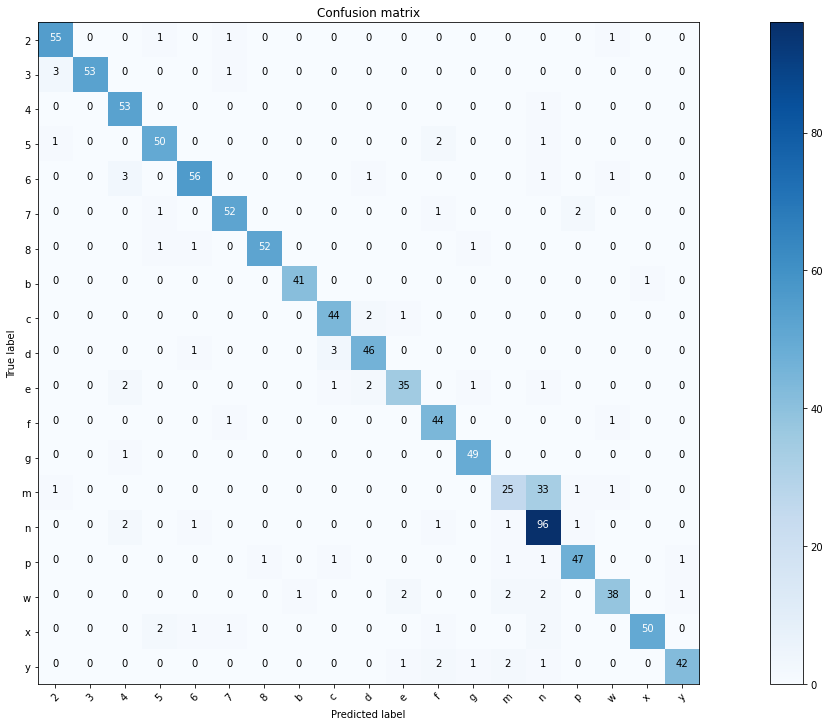

In [84]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize = (20,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# menghitung confusion matrix
confusion_mtx = confusion_matrix(yres, pred) 

# plot confusion matrix
plot_confusion_matrix(confusion_mtx, classes = y_label) 

In [113]:
yres.shape

(1040,)

In [114]:
pred.shape

(1040,)

# Testing Model

In [85]:

def input_predict (img_path) :
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(img, 'gray')
    plt.axis('off')
    plt.show()
    
    img = t_img(img)
    img = c_img(img)
    img = d_img(img)
    img = b_img(img)
    
    image_list = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
    
    plt.imshow(img, 'gray')
    plt.axis('off')
    plt.show()
    Xdemo = []
    for i in range(5) :
        Xdemo.append(img_to_array(Image.fromarray(image_list[i])))
    
    Xdemo = np.array(Xdemo)
    Xdemo/= 255.0
    
    ydemo = model.predict(Xdemo)
    ydemo = np.argmax(ydemo, axis = 1)
    
    print("Predicted Captcha : ", end="")
    for res in ydemo :
        print(info[res], end="")
    print()
    
    print("Real Captcha : ", end="")
    print(img_path[-9:])
    print()

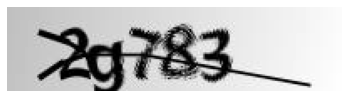

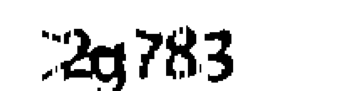

Predicted Captcha : 2g783
Real Captcha : 2g783.png



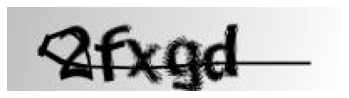

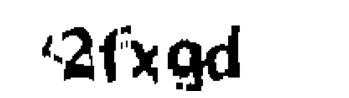

Predicted Captcha : 2fxgd
Real Captcha : 2fxgd.png



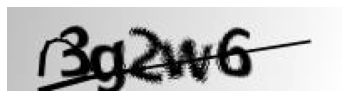

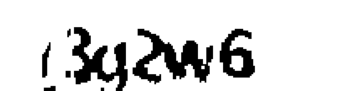

Predicted Captcha : 3g2wd
Real Captcha : 3g2w6.png



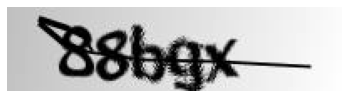

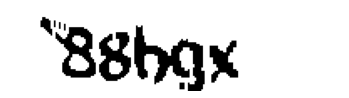

Predicted Captcha : 88bgx
Real Captcha : 88bgx.png



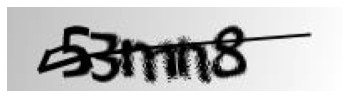

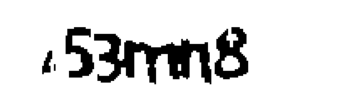

Predicted Captcha : 53nm8
Real Captcha : 53mn8.png



In [86]:
input_predict('input/2g783.png')
input_predict('input/2fxgd.png')
input_predict('input/3g2w6.png')
input_predict('input/88bgx.png')
input_predict('input/53mn8.png')